<a href="https://colab.research.google.com/github/gcosma/DECODEclinicalTrialCalc/blob/main/Coopers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title COOPER ET AL.
import math

def calculate_sample_size(p1, p2, alpha=0.05, power=0.9, icc=0.05, cluster_size=6, attrition=0.2):
    """
    Calculate sample size for a cluster-randomized trial comparing enhanced AHC to standard AHC.

    Parameters:
    -----------
    p1 : float
        Expected proportion of health needs identified in standard AHC group (e.g., 0.5 for 50%)
    p2 : float
        Expected proportion of health needs identified in enhanced AHC group (e.g., 0.75 for 75%)
    alpha : float
        Significance level (default: 0.05)
    power : float
        Statistical power (default: 0.9 for 90% power)
    icc : float
        Intraclass correlation coefficient (default: 0.05)
    cluster_size : float
        Average number of participants per cluster (default: 6)
    attrition : float
        Expected attrition rate (default: 0.2 for 20%)
    """

    # Get z-values
    z_values = {0.01: 2.576, 0.05: 1.96, 0.1: 1.645}
    power_values = {0.8: 0.84, 0.9: 1.28, 0.7: 0.67}

    z_alpha = z_values.get(alpha, 1.96)
    z_beta = power_values.get(power, 1.28)

    # Calculate basic sample size (without clustering)
    p = (p1 + p2) / 2
    base_n = math.ceil(
        ((z_alpha + z_beta) ** 2 * (2 * p * (1 - p))) / ((p2 - p1) ** 2)
    )

    # Design effect for cluster randomization
    design_effect = 1 + (cluster_size - 1) * icc

    # Calculate sample size with clustering
    cluster_adjusted_n = math.ceil(base_n * design_effect)

    # Adjust for attrition
    final_n = math.ceil(cluster_adjusted_n / (1 - attrition))

    # Calculate number of clusters needed
    clusters_per_arm = math.ceil(final_n / (2 * cluster_size))
    total_clusters = clusters_per_arm * 2

    # Calculate participants per arm and total participants
    participants_per_arm = math.ceil(final_n / 2)
    total_participants = participants_per_arm * 2

    return {
        "base_n": base_n,
        "design_effect": design_effect,
        "cluster_adjusted_n": cluster_adjusted_n,
        "final_n": final_n,
        "participants_per_arm": participants_per_arm,
        "clusters_per_arm": clusters_per_arm,
        "total_clusters": total_clusters,
        "total_participants": total_participants
    }

# Calculate sample size with your new parameters
new_params = calculate_sample_size(
    p1=0.5,   # Standard AHC identifies conditions with 50% accuracy
    p2=0.75,  # Enhanced AHC identifies conditions with 75% accuracy
    alpha=0.05,
    power=0.9,
    icc=0.05,
    cluster_size=6,
    attrition=0.2
)

# Calculate original parameters from Cooper et al. for comparison
original_params = calculate_sample_size(
    p1=0.33,  # Expected proportion in control group (standard care)
    p2=0.66,  # Expected proportion in intervention group (health check)
    alpha=0.05,
    power=0.9,
    icc=0.05,
    cluster_size=6,
    attrition=0.2
)

# Display the results
print("NEW SCENARIO: Standard AHC (50%) vs Enhanced AHC (75%)")
print("=" * 70)
print(f"Base sample size (without clustering): {new_params['base_n']} participants")
print(f"Design effect: {new_params['design_effect']:.2f}")
print(f"Cluster-adjusted sample size: {new_params['cluster_adjusted_n']} participants")
print(f"Final sample size after attrition adjustment: {new_params['final_n']} participants")
print(f"Required participants per arm: {new_params['participants_per_arm']}")
print(f"Required practices (clusters) per arm: {new_params['clusters_per_arm']}")
print(f"Total participants needed: {new_params['total_participants']}")
print(f"Total practices needed: {new_params['total_clusters']}")

print("\nCOMPARISON WITH COOPER ET AL. STUDY: Standard Care (33%) vs Health Check (66%)")
print("=" * 70)
print(f"Base sample size (without clustering): {original_params['base_n']} participants")
print(f"Design effect: {original_params['design_effect']:.2f}")
print(f"Cluster-adjusted sample size: {original_params['cluster_adjusted_n']} participants")
print(f"Final sample size after attrition adjustment: {original_params['final_n']} participants")
print(f"Required participants per arm: {original_params['participants_per_arm']}")
print(f"Required practices (clusters) per arm: {original_params['clusters_per_arm']}")
print(f"Total participants needed: {original_params['total_participants']}")
print(f"Total practices needed: {original_params['total_clusters']}")

NEW SCENARIO: Standard AHC (50%) vs Enhanced AHC (75%)
Base sample size (without clustering): 79 participants
Design effect: 1.25
Cluster-adjusted sample size: 99 participants
Final sample size after attrition adjustment: 124 participants
Required participants per arm: 62
Required practices (clusters) per arm: 11
Total participants needed: 124
Total practices needed: 22

COMPARISON WITH COOPER ET AL. STUDY: Standard Care (33%) vs Health Check (66%)
Base sample size (without clustering): 49 participants
Design effect: 1.25
Cluster-adjusted sample size: 62 participants
Final sample size after attrition adjustment: 78 participants
Required participants per arm: 39
Required practices (clusters) per arm: 7
Total participants needed: 78
Total practices needed: 14


In [7]:
#Cooper
import numpy as np
import scipy.stats as stats
import math

def calculate_sample_size(
    p1,           # proportion in control group
    p2,           # proportion in intervention group
    alpha=0.05,   # significance level
    power=0.8,    # power (1-beta)
    icc=0.05,     # intraclass correlation coefficient
    m=5,          # average cluster size
    attrition=0.2 # expected attrition rate
):
    """
    Calculate sample size for cluster randomized trial.

    Parameters:
    ----------
    p1 : float
        Expected proportion in control group (between 0 and 1)
    p2 : float
        Expected proportion in intervention group (between 0 and 1)
    alpha : float
        Significance level (default: 0.05)
    power : float
        Power (1-beta) (default: 0.8)
    icc : float
        Intraclass correlation coefficient (default: 0.05)
    m : int
        Average cluster size (default: 5)
    attrition : float
        Expected attrition rate (default: 0.2)

    Returns:
    -------
    dict
        Dictionary containing sample size calculations
    """
    # Calculate required z values
    z_alpha = stats.norm.ppf(1 - alpha/2)
    z_beta = stats.norm.ppf(power)

    # Calculate base sample size (without clustering)
    n_per_arm = ((z_alpha + z_beta)**2 * (p1 * (1 - p1) + p2 * (1 - p2))) / ((p1 - p2)**2)
    n_total_base = 2 * n_per_arm

    # Calculate design effect
    design_effect = 1 + (m - 1) * icc

    # Apply design effect to get cluster-adjusted sample size
    n_total_cluster_adjusted = n_total_base * design_effect
    n_per_arm_cluster_adjusted = n_total_cluster_adjusted / 2

    # Adjust for attrition
    n_total_final = n_total_cluster_adjusted / (1 - attrition)
    n_per_arm_final = n_total_final / 2

    # Calculate number of clusters needed
    clusters_per_arm = math.ceil(n_per_arm_final / m)
    total_clusters = 2 * clusters_per_arm

    # Calculate odds ratio (for reference)
    odds_ratio = (p2 / (1 - p2)) / (p1 / (1 - p1))

    return {
        "odds_ratio": round(odds_ratio, 2),
        "base_sample_size": round(n_total_base),
        "design_effect": round(design_effect, 2),
        "cluster_adjusted_sample_size": round(n_total_cluster_adjusted),
        "final_sample_size": round(n_total_final),
        "participants_per_arm": round(n_per_arm_final),
        "clusters_per_arm": clusters_per_arm,
        "total_participants": round(n_total_final),
        "total_clusters": total_clusters
    }

# USER INPUTS - MODIFY THESE VALUES
# =================================

# Your comparison
p1 = 0.50  # Standard AHC success rate (50%)
p2 = 0.75  # Enhanced AHC success rate (75%)

# Study design parameters
icc = 0.05  # Intraclass correlation (clustering effect)
m = 5       # Participants per practice
attrition = 0.2  # Expected dropout rate (20%)

# RUN CALCULATION
# ==============

# Calculate required sample size
result = calculate_sample_size(p1, p2, icc=icc, m=m, attrition=attrition)

# DISPLAY RESULTS
# ==============

print(f"COMPARISON: Standard AHC ({p1*100:.0f}%) vs Enhanced AHC ({p2*100:.0f}%)")
print("="*70)
print(f"Absolute difference to detect: {(p2-p1)*100:.0f}%")
print(f"Equivalent odds ratio: {result['odds_ratio']}")
print("\nSTUDY DESIGN PARAMETERS:")
print(f"- Clustering effect (ICC): {icc}")
print(f"- Participants per practice: {m}")
print(f"- Expected dropout rate: {attrition*100:.0f}%")

print("\nSAMPLE SIZE CALCULATION RESULTS:")
print(f"1. Base sample size (simple RCT): {result['base_sample_size']} participants")
print(f"2. Adjustment for clustering: x{result['design_effect']} → {result['cluster_adjusted_sample_size']} participants")
print(f"3. Adjustment for dropout: ÷{1-attrition} → {result['final_sample_size']} participants")

print("\nFINAL RECRUITMENT TARGETS:")
print(f"- Participants per arm: {result['participants_per_arm']}")
print(f"- Practices per arm: {result['clusters_per_arm']}")
print(f"- TOTAL PARTICIPANTS: {result['total_participants']}")
print(f"- TOTAL PRACTICES: {result['total_clusters']}")

# EXPLANATION OF RESULTS
# =====================

print("\nEXPLANATION:")
print("-" * 70)
print("This calculator determines how many participants and practices")
print("you need to recruit for your cluster randomized trial comparing")
print("Standard vs Enhanced Annual Health Checks.")
print("\nThe calculation process:")
print("1. Start with basic sample size for a simple randomized trial")
print("2. Increase sample size to account for clustering of participants within practices")
print("3. Further increase to account for expected dropout during the study")
print("\nThe final numbers represent your initial recruitment targets to ensure")
print("adequate statistical power (80%) to detect the specified difference")
print("between your interventions with 95% confidence.")

# SENSITIVITY ANALYSIS
# ===================

print("\nSENSITIVITY ANALYSIS:")
print("-" * 70)
print("How sample size requirements change with different parameters:")

# ICC sensitivity
print("\n1. Effect of changing ICC value:")
for test_icc in [0.01, 0.03, 0.05, 0.07, 0.10]:
    test_result = calculate_sample_size(p1, p2, icc=test_icc, m=m, attrition=attrition)
    print(f"   ICC = {test_icc:.2f}: {test_result['participants_per_arm']} participants per arm ({test_result['clusters_per_arm']} practices per arm)")

# Cluster size sensitivity
print("\n2. Effect of changing cluster size (participants per practice):")
for test_m in [3, 5, 7, 10, 15]:
    test_result = calculate_sample_size(p1, p2, icc=icc, m=test_m, attrition=attrition)
    print(f"   Size = {test_m}: {test_result['participants_per_arm']} participants per arm ({test_result['clusters_per_arm']} practices per arm)")

# Effect size sensitivity
print("\n3. Effect of changing the difference between groups:")
for diff in [0.15, 0.20, 0.25, 0.30, 0.35]:
    test_p2 = p1 + diff
    if test_p2 <= 1.0:  # Ensure proportion doesn't exceed 1
        test_result = calculate_sample_size(p1, test_p2, icc=icc, m=m, attrition=attrition)
        print(f"   Difference = {diff*100:.0f}%: {test_result['participants_per_arm']} participants per arm ({test_result['clusters_per_arm']} practices per arm)")

COMPARISON: Standard AHC (50%) vs Enhanced AHC (75%)
Absolute difference to detect: 25%
Equivalent odds ratio: 3.0

STUDY DESIGN PARAMETERS:
- Clustering effect (ICC): 0.05
- Participants per practice: 5
- Expected dropout rate: 20%

SAMPLE SIZE CALCULATION RESULTS:
1. Base sample size (simple RCT): 110 participants
2. Adjustment for clustering: x1.2 → 132 participants
3. Adjustment for dropout: ÷0.8 → 165 participants

FINAL RECRUITMENT TARGETS:
- Participants per arm: 82
- Practices per arm: 17
- TOTAL PARTICIPANTS: 165
- TOTAL PRACTICES: 34

EXPLANATION:
----------------------------------------------------------------------
This calculator determines how many participants and practices
you need to recruit for your cluster randomized trial comparing
Standard vs Enhanced Annual Health Checks.

The calculation process:
1. Start with basic sample size for a simple randomized trial
2. Increase sample size to account for clustering of participants within practices
3. Further increase to a

CLUSTER RANDOMIZED TRIAL SAMPLE SIZE CALCULATOR
This notebook provides two approaches to calculate sample size for cluster randomized trials:
1. Cooper Approach: Function-based with comprehensive sensitivity analysis
2. Lennox Approach: Step-by-step calculation with clear parameter entry

Both approaches use your specified parameters:
- Control proportion (p1): 0.50 (50%)
- Intervention proportion (p2): 0.75 (75%)
- Significance level (alpha): 0.05
- Power (1-beta): 0.9
- ICC: 0.05
- Cluster size: 6
- Attrition rate: 20%
COOPER APPROACH: FUNCTION-BASED WITH SENSITIVITY ANALYSIS
COMPARISON: Standard AHC (50%) vs Enhanced AHC (75%)
Absolute difference to detect: 25%
Equivalent odds ratio: 3.0

STUDY DESIGN PARAMETERS:
- Significance level (alpha): 0.05
- Power (1-beta): 0.9
- Clustering effect (ICC): 0.05
- Participants per practice: 6
- Expected dropout rate: 20%

SAMPLE SIZE CALCULATION RESULTS:
1. Base sample size (simple RCT): 147 participants
2. Adjustment for clustering: x1.25 → 18

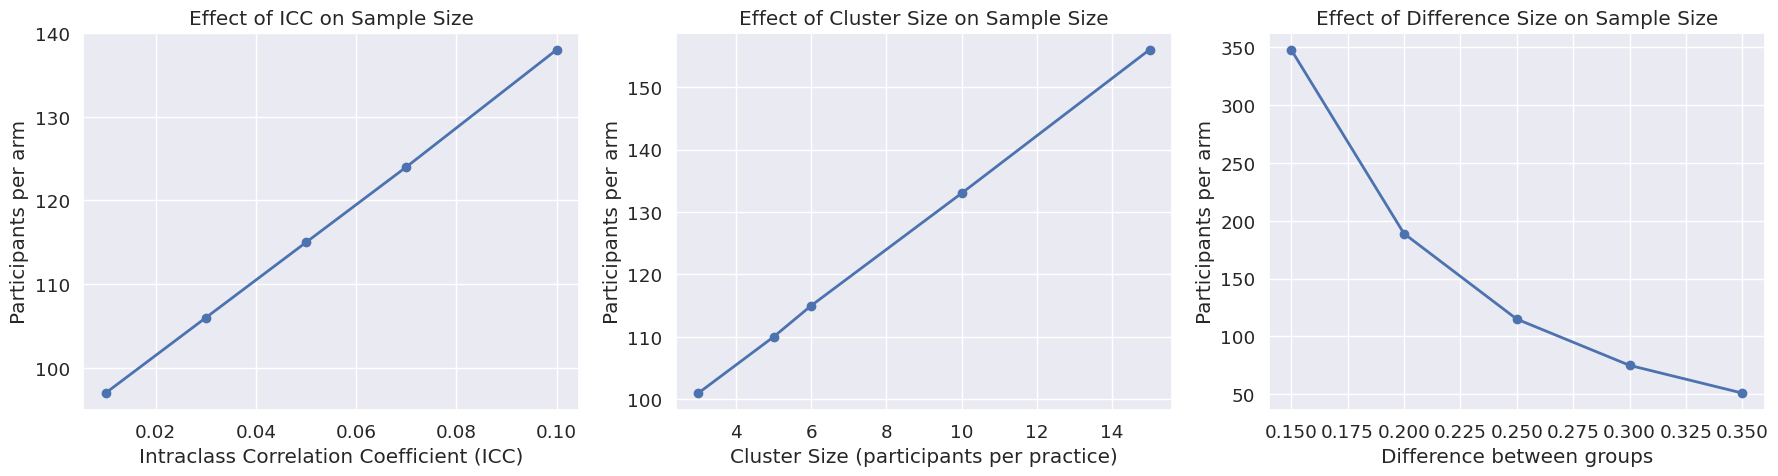



LENNOX APPROACH: STEP-BY-STEP CALCULATION
SAMPLE SIZE CALCULATION FOR CLUSTER RANDOMIZED TRIAL

INPUT PARAMETERS:
- Control group proportion (p1): 0.50 (50%)
- Intervention group proportion (p2): 0.75 (75%)
- Absolute difference to detect: 25%
- Equivalent odds ratio: 3.00
- Significance level (alpha): 0.05
- Power (1-beta): 0.9
- Intraclass correlation (ICC): 0.05
- Average cluster size (m): 6
- Expected attrition rate: 20%

CALCULATION STEPS:
1. Basic sample size for simple RCT: 147 participants (74 per arm)
2. Design effect due to clustering: 1.25
3. Sample size adjusted for clustering: 184 participants (92 per arm)
4. Final sample size with attrition adjustment: 230 participants (115 per arm)
5. Required clusters: 20 per arm, 40 total

FINAL RECRUITMENT TARGETS:
PARTICIPANTS PER ARM: 115
TOTAL PARTICIPANTS: 230
PRACTICES PER ARM: 20
TOTAL PRACTICES: 40


COMPARISON BETWEEN COOPER AND LENNOX APPROACHES
Both approaches use the same core calculation method with your specified parame

In [9]:
# Cluster Randomized Controlled Trial Sample Size Calculator
# Combines Cooper and Lennox approaches with customizable settings

import numpy as np
import scipy.stats as stats
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

# ==========================================================
# SHARED USER PARAMETERS - MODIFY THESE VALUES
# ==========================================================

# Study parameters - modify these for your specific study
p1 = 0.50           # proportion in control group
p2 = 0.75           # proportion in intervention group
alpha = 0.05        # significance level
power = 0.9         # power (1-beta)
icc = 0.05          # intraclass correlation coefficient
m = 6               # average cluster size
attrition = 0.2     # expected attrition rate (20%)

# ==========================================================
# COOPER APPROACH: Function-based with sensitivity analysis
# ==========================================================

def calculate_sample_size_cooper(
    p1,           # proportion in control group
    p2,           # proportion in intervention group
    alpha=0.05,   # significance level
    power=0.8,    # power (1-beta)
    icc=0.05,     # intraclass correlation coefficient
    m=5,          # average cluster size
    attrition=0.2 # expected attrition rate
):
    """
    Calculate sample size for cluster randomized trial (Cooper approach).

    Parameters:
    ----------
    p1 : float
        Expected proportion in control group (between 0 and 1)
    p2 : float
        Expected proportion in intervention group (between 0 and 1)
    alpha : float
        Significance level (default: 0.05)
    power : float
        Power (1-beta) (default: 0.8)
    icc : float
        Intraclass correlation coefficient (default: 0.05)
    m : int
        Average cluster size (default: 5)
    attrition : float
        Expected attrition rate (default: 0.2)

    Returns:
    -------
    dict
        Dictionary containing sample size calculations
    """
    # Calculate required z values
    z_alpha = stats.norm.ppf(1 - alpha/2)
    z_beta = stats.norm.ppf(power)

    # Calculate base sample size (without clustering)
    n_per_arm = ((z_alpha + z_beta)**2 * (p1 * (1 - p1) + p2 * (1 - p2))) / ((p1 - p2)**2)
    n_total_base = 2 * n_per_arm

    # Calculate design effect
    design_effect = 1 + (m - 1) * icc

    # Apply design effect to get cluster-adjusted sample size
    n_total_cluster_adjusted = n_total_base * design_effect
    n_per_arm_cluster_adjusted = n_total_cluster_adjusted / 2

    # Adjust for attrition
    n_total_final = n_total_cluster_adjusted / (1 - attrition)
    n_per_arm_final = n_total_final / 2

    # Calculate number of clusters needed
    clusters_per_arm = math.ceil(n_per_arm_final / m)
    total_clusters = 2 * clusters_per_arm

    # Calculate odds ratio (for reference)
    odds_ratio = (p2 / (1 - p2)) / (p1 / (1 - p1))

    return {
        "odds_ratio": round(odds_ratio, 2),
        "base_sample_size": round(n_total_base),
        "design_effect": round(design_effect, 2),
        "cluster_adjusted_sample_size": round(n_total_cluster_adjusted),
        "final_sample_size": round(n_total_final),
        "participants_per_arm": round(n_per_arm_final),
        "clusters_per_arm": clusters_per_arm,
        "total_participants": round(n_total_final),
        "total_clusters": total_clusters
    }

def run_cooper_approach():
    # Calculate required sample size
    result = calculate_sample_size_cooper(p1, p2, alpha=alpha, power=power, icc=icc, m=m, attrition=attrition)

    print("COOPER APPROACH: FUNCTION-BASED WITH SENSITIVITY ANALYSIS")
    print("=" * 70)
    print(f"COMPARISON: Standard AHC ({p1*100:.0f}%) vs Enhanced AHC ({p2*100:.0f}%)")
    print("=" * 70)
    print(f"Absolute difference to detect: {(p2-p1)*100:.0f}%")
    print(f"Equivalent odds ratio: {result['odds_ratio']}")
    print("\nSTUDY DESIGN PARAMETERS:")
    print(f"- Significance level (alpha): {alpha}")
    print(f"- Power (1-beta): {power}")
    print(f"- Clustering effect (ICC): {icc}")
    print(f"- Participants per practice: {m}")
    print(f"- Expected dropout rate: {attrition*100:.0f}%")

    print("\nSAMPLE SIZE CALCULATION RESULTS:")
    print(f"1. Base sample size (simple RCT): {result['base_sample_size']} participants")
    print(f"2. Adjustment for clustering: x{result['design_effect']} → {result['cluster_adjusted_sample_size']} participants")
    print(f"3. Adjustment for dropout: ÷{1-attrition} → {result['final_sample_size']} participants")

    print("\nFINAL RECRUITMENT TARGETS:")
    print(f"- Participants per arm: {result['participants_per_arm']}")
    print(f"- Practices per arm: {result['clusters_per_arm']}")
    print(f"- TOTAL PARTICIPANTS: {result['total_participants']}")
    print(f"- TOTAL PRACTICES: {result['total_clusters']}")

    print("\nEXPLANATION:")
    print("-" * 70)
    print("The calculation process:")
    print("1. Start with basic sample size for a simple randomized trial")
    print("2. Increase sample size to account for clustering of participants within practices")
    print("3. Further increase to account for expected dropout during the study")

    # Run sensitivity analyses
    print("\nSENSITIVITY ANALYSIS:")
    print("-" * 70)
    print("How sample size requirements change with different parameters:")

    # ICC sensitivity
    print("\n1. Effect of changing ICC value:")
    icc_values = [0.01, 0.03, 0.05, 0.07, 0.10]
    icc_results = []

    for test_icc in icc_values:
        test_result = calculate_sample_size_cooper(p1, p2, alpha=alpha, power=power, icc=test_icc, m=m, attrition=attrition)
        icc_results.append(test_result['participants_per_arm'])
        print(f"   ICC = {test_icc:.2f}: {test_result['participants_per_arm']} participants per arm ({test_result['clusters_per_arm']} practices per arm)")

    # Cluster size sensitivity
    print("\n2. Effect of changing cluster size (participants per practice):")
    m_values = [3, 5, 6, 10, 15]
    m_results = []

    for test_m in m_values:
        test_result = calculate_sample_size_cooper(p1, p2, alpha=alpha, power=power, icc=icc, m=test_m, attrition=attrition)
        m_results.append(test_result['participants_per_arm'])
        print(f"   Size = {test_m}: {test_result['participants_per_arm']} participants per arm ({test_result['clusters_per_arm']} practices per arm)")

    # Effect size sensitivity
    print("\n3. Effect of changing the difference between groups:")
    diff_values = [0.15, 0.20, 0.25, 0.30, 0.35]
    diff_results = []

    for diff in diff_values:
        test_p2 = p1 + diff
        if test_p2 <= 1.0:  # Ensure proportion doesn't exceed 1
            test_result = calculate_sample_size_cooper(p1, test_p2, alpha=alpha, power=power, icc=icc, m=m, attrition=attrition)
            diff_results.append(test_result['participants_per_arm'])
            print(f"   Difference = {diff*100:.0f}%: {test_result['participants_per_arm']} participants per arm ({test_result['clusters_per_arm']} practices per arm)")
        else:
            diff_results.append(None)

    # Create sensitivity analysis plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot ICC sensitivity
    axes[0].plot(icc_values, icc_results, 'o-', linewidth=2)
    axes[0].set_xlabel('Intraclass Correlation Coefficient (ICC)')
    axes[0].set_ylabel('Participants per arm')
    axes[0].set_title('Effect of ICC on Sample Size')
    axes[0].grid(True)

    # Plot cluster size sensitivity
    axes[1].plot(m_values, m_results, 'o-', linewidth=2)
    axes[1].set_xlabel('Cluster Size (participants per practice)')
    axes[1].set_ylabel('Participants per arm')
    axes[1].set_title('Effect of Cluster Size on Sample Size')
    axes[1].grid(True)

    # Plot effect size sensitivity
    valid_diffs = [diff_values[i] for i in range(len(diff_values)) if diff_results[i] is not None]
    valid_results = [r for r in diff_results if r is not None]
    axes[2].plot(valid_diffs, valid_results, 'o-', linewidth=2)
    axes[2].set_xlabel('Difference between groups')
    axes[2].set_ylabel('Participants per arm')
    axes[2].set_title('Effect of Difference Size on Sample Size')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

    return result

# ==========================================================
# LENNOX APPROACH: Step-by-step calculation
# ==========================================================

def run_lennox_approach():
    print("\n\nLENNOX APPROACH: STEP-BY-STEP CALCULATION")
    print("=" * 70)

    # Calculate required z values
    z_alpha = stats.norm.ppf(1 - alpha/2)
    z_beta = stats.norm.ppf(power)

    # Calculate base sample size (without clustering)
    n_per_arm = ((z_alpha + z_beta)**2 * (p1 * (1 - p1) + p2 * (1 - p2))) / ((p1 - p2)**2)
    n_total_base = 2 * n_per_arm

    # Calculate design effect
    design_effect = 1 + (m - 1) * icc

    # Apply design effect to get cluster-adjusted sample size
    n_total_cluster_adjusted = n_total_base * design_effect
    n_per_arm_cluster_adjusted = n_total_cluster_adjusted / 2

    # Adjust for attrition
    n_total_final = n_total_cluster_adjusted / (1 - attrition)
    n_per_arm_final = n_total_final / 2

    # Calculate number of clusters needed
    clusters_per_arm = math.ceil(n_per_arm_final / m)
    total_clusters = 2 * clusters_per_arm

    # Calculate odds ratio (for reference)
    odds_ratio = (p2 / (1 - p2)) / (p1 / (1 - p1))

    print(f"SAMPLE SIZE CALCULATION FOR CLUSTER RANDOMIZED TRIAL")
    print("=" * 70)

    print("\nINPUT PARAMETERS:")
    print(f"- Control group proportion (p1): {p1:.2f} ({p1*100:.0f}%)")
    print(f"- Intervention group proportion (p2): {p2:.2f} ({p2*100:.0f}%)")
    print(f"- Absolute difference to detect: {(p2-p1)*100:.0f}%")
    print(f"- Equivalent odds ratio: {odds_ratio:.2f}")
    print(f"- Significance level (alpha): {alpha}")
    print(f"- Power (1-beta): {power}")
    print(f"- Intraclass correlation (ICC): {icc}")
    print(f"- Average cluster size (m): {m}")
    print(f"- Expected attrition rate: {attrition*100:.0f}%")

    print("\nCALCULATION STEPS:")
    print(f"1. Basic sample size for simple RCT: {round(n_total_base)} participants ({round(n_per_arm)} per arm)")
    print(f"2. Design effect due to clustering: {design_effect:.2f}")
    print(f"3. Sample size adjusted for clustering: {round(n_total_cluster_adjusted)} participants ({round(n_per_arm_cluster_adjusted)} per arm)")
    print(f"4. Final sample size with attrition adjustment: {round(n_total_final)} participants ({round(n_per_arm_final)} per arm)")
    print(f"5. Required clusters: {clusters_per_arm} per arm, {total_clusters} total")

    print("\nFINAL RECRUITMENT TARGETS:")
    print("=" * 50)
    print(f"PARTICIPANTS PER ARM: {round(n_per_arm_final)}")
    print(f"TOTAL PARTICIPANTS: {round(n_total_final)}")
    print(f"PRACTICES PER ARM: {clusters_per_arm}")
    print(f"TOTAL PRACTICES: {total_clusters}")

    lennox_result = {
        "odds_ratio": round(odds_ratio, 2),
        "base_sample_size": round(n_total_base),
        "design_effect": round(design_effect, 2),
        "cluster_adjusted_sample_size": round(n_total_cluster_adjusted),
        "final_sample_size": round(n_total_final),
        "participants_per_arm": round(n_per_arm_final),
        "clusters_per_arm": clusters_per_arm,
        "total_participants": round(n_total_final),
        "total_clusters": total_clusters
    }

    return lennox_result

# ==========================================================
# COMPARISON BETWEEN APPROACHES
# ==========================================================

def compare_approaches():
    # Run both approaches
    cooper_result = calculate_sample_size_cooper(p1, p2, alpha=alpha, power=power, icc=icc, m=m, attrition=attrition)

    # Calculate using Lennox approach directly
    z_alpha = stats.norm.ppf(1 - alpha/2)
    z_beta = stats.norm.ppf(power)
    n_per_arm = ((z_alpha + z_beta)**2 * (p1 * (1 - p1) + p2 * (1 - p2))) / ((p1 - p2)**2)
    n_total_base = 2 * n_per_arm
    design_effect = 1 + (m - 1) * icc
    n_total_cluster_adjusted = n_total_base * design_effect
    n_total_final = n_total_cluster_adjusted / (1 - attrition)
    n_per_arm_final = n_total_final / 2
    clusters_per_arm = math.ceil(n_per_arm_final / m)

    lennox_result = {
        "participants_per_arm": round(n_per_arm_final),
        "clusters_per_arm": clusters_per_arm,
        "total_participants": round(n_total_final)
    }

    print("\n\nCOMPARISON BETWEEN COOPER AND LENNOX APPROACHES")
    print("=" * 70)
    print("Both approaches use the same core calculation method with your specified parameters:")
    print(f"- Control proportion: {p1:.2f} ({p1*100:.0f}%)")
    print(f"- Intervention proportion: {p2:.2f} ({p2*100:.0f}%)")
    print(f"- Significance level: {alpha}")
    print(f"- Power: {power}")
    print(f"- ICC: {icc}")
    print(f"- Cluster size: {m}")
    print(f"- Attrition rate: {attrition*100:.0f}%")

    print("\nRESULTS COMPARISON:")
    print("-" * 70)
    comparison_df = pd.DataFrame({
        'Cooper Approach': [cooper_result['participants_per_arm'], cooper_result['clusters_per_arm'], cooper_result['total_participants']],
        'Lennox Approach': [lennox_result['participants_per_arm'], lennox_result['clusters_per_arm'], lennox_result['total_participants']]
    }, index=['Participants per arm', 'Clusters per arm', 'Total participants'])

    print(comparison_df)
    print("\nNote: The results are identical because both approaches use the same statistical methodology.")
    print("The difference is in presentation and additional analyses (Cooper approach provides sensitivity analysis).")

# ==========================================================
# MAIN EXECUTION
# ==========================================================

print("CLUSTER RANDOMIZED TRIAL SAMPLE SIZE CALCULATOR")
print("=" * 70)
print("This notebook provides two approaches to calculate sample size for cluster randomized trials:")
print("1. Cooper Approach: Function-based with comprehensive sensitivity analysis")
print("2. Lennox Approach: Step-by-step calculation with clear parameter entry")
print("\nBoth approaches use your specified parameters:")
print(f"- Control proportion (p1): {p1:.2f} ({p1*100:.0f}%)")
print(f"- Intervention proportion (p2): {p2:.2f} ({p2*100:.0f}%)")
print(f"- Significance level (alpha): {alpha}")
print(f"- Power (1-beta): {power}")
print(f"- ICC: {icc}")
print(f"- Cluster size: {m}")
print(f"- Attrition rate: {attrition*100:.0f}%")

# Run Cooper approach
cooper_result = run_cooper_approach()

# Run Lennox approach
lennox_result = run_lennox_approach()

# Compare approaches
compare_approaches()

In [8]:
#Lennox
import numpy as np
import scipy.stats as stats
import math

# ==========================================================
# STEP 1: ENTER YOUR PARAMETERS HERE
# ==========================================================

# Replace these values with your specific parameters
p1 = 0.50           # proportion in control group (Standard AHC)
p2 = 0.75           # proportion in intervention group (Enhanced AHC)
alpha = 0.05        # significance level
power = 0.9         # power (1-beta) - changed from 0.8 to 0.9 as requested
icc = 0.05          # intraclass correlation coefficient
m = 6               # average cluster size - changed from 5 to 6 as requested
attrition = 0.2     # expected attrition rate (20%)

# ==========================================================
# STEP 2: CALCULATION - DO NOT MODIFY THIS SECTION
# ==========================================================

# Calculate required z values
z_alpha = stats.norm.ppf(1 - alpha/2)
z_beta = stats.norm.ppf(power)

# Calculate base sample size (without clustering)
n_per_arm = ((z_alpha + z_beta)**2 * (p1 * (1 - p1) + p2 * (1 - p2))) / ((p1 - p2)**2)
n_total_base = 2 * n_per_arm

# Calculate design effect
design_effect = 1 + (m - 1) * icc

# Apply design effect to get cluster-adjusted sample size
n_total_cluster_adjusted = n_total_base * design_effect
n_per_arm_cluster_adjusted = n_total_cluster_adjusted / 2

# Adjust for attrition
n_total_final = n_total_cluster_adjusted / (1 - attrition)
n_per_arm_final = n_total_final / 2

# Calculate number of clusters needed
clusters_per_arm = math.ceil(n_per_arm_final / m)
total_clusters = 2 * clusters_per_arm

# Calculate odds ratio (for reference)
odds_ratio = (p2 / (1 - p2)) / (p1 / (1 - p1))

# ==========================================================
# STEP 3: RESULTS DISPLAY
# ==========================================================

print(f"SAMPLE SIZE CALCULATION FOR CLUSTER RANDOMIZED TRIAL")
print("=" * 70)

print("\nINPUT PARAMETERS:")
print(f"- Control group proportion (p1): {p1:.2f} ({p1*100:.0f}%)")
print(f"- Intervention group proportion (p2): {p2:.2f} ({p2*100:.0f}%)")
print(f"- Absolute difference to detect: {(p2-p1)*100:.0f}%")
print(f"- Equivalent odds ratio: {odds_ratio:.2f}")
print(f"- Significance level (alpha): {alpha}")
print(f"- Power (1-beta): {power}")
print(f"- Intraclass correlation (ICC): {icc}")
print(f"- Average cluster size (m): {m}")
print(f"- Expected attrition rate: {attrition*100:.0f}%")

print("\nCALCULATION STEPS:")
print(f"1. Basic sample size for simple RCT: {round(n_total_base)} participants ({round(n_per_arm)} per arm)")
print(f"2. Design effect due to clustering: {design_effect:.2f}")
print(f"3. Sample size adjusted for clustering: {round(n_total_cluster_adjusted)} participants ({round(n_per_arm_cluster_adjusted)} per arm)")
print(f"4. Final sample size with attrition adjustment: {round(n_total_final)} participants ({round(n_per_arm_final)} per arm)")
print(f"5. Required clusters: {clusters_per_arm} per arm, {total_clusters} total")

print("\nFINAL RECRUITMENT TARGETS:")
print("=" * 50)
print(f"PARTICIPANTS PER ARM: {round(n_per_arm_final)}")
print(f"TOTAL PARTICIPANTS: {round(n_total_final)}")
print(f"PRACTICES PER ARM: {clusters_per_arm}")
print(f"TOTAL PRACTICES: {total_clusters}")

SAMPLE SIZE CALCULATION FOR CLUSTER RANDOMIZED TRIAL

INPUT PARAMETERS:
- Control group proportion (p1): 0.50 (50%)
- Intervention group proportion (p2): 0.75 (75%)
- Absolute difference to detect: 25%
- Equivalent odds ratio: 3.00
- Significance level (alpha): 0.05
- Power (1-beta): 0.9
- Intraclass correlation (ICC): 0.05
- Average cluster size (m): 6
- Expected attrition rate: 20%

CALCULATION STEPS:
1. Basic sample size for simple RCT: 147 participants (74 per arm)
2. Design effect due to clustering: 1.25
3. Sample size adjusted for clustering: 184 participants (92 per arm)
4. Final sample size with attrition adjustment: 230 participants (115 per arm)
5. Required clusters: 20 per arm, 40 total

FINAL RECRUITMENT TARGETS:
PARTICIPANTS PER ARM: 115
TOTAL PARTICIPANTS: 230
PRACTICES PER ARM: 20
TOTAL PRACTICES: 40
